In [9]:
from pandas import read_csv
import datetime
from pandas import Series, DataFrame
# load data
dataset = read_csv('B.csv')
# manually specify column names
dataset.columns = ['Date','First', 'High','Low', 'Close', 'Value', 'Vol', 'Openint', 'Per','Open','Last']
dataset.index = dataset['Date']
dataset.drop('Date', axis=1, inplace=True)
dataset.drop('Per', axis=1, inplace=True)
dataset = dataset[dataset > 0]
# drop the first 24 hours
dataset = dataset[(24*12):]
# summarize first 5 rows
display(dataset.head(5))
# save to file
dataset.to_csv('B copy.csv')

,First,High,Low,Close,Value,Vol,Openint,Open,Last
Date,,,,,,,,,
20180207,1519,1529,1491,1500,1.500659e+08,99580,37,1499.0,1503
20180206,1492,1515,1492,1499,1.596254e+09,1064598,109,1499.0,1500
20180205,1498,1510,1491,1499,1.136826e+09,758431,97,1492.0,1510
20180204,1500,1520,1470,1492,1.016575e+09,684107,127,1544.0,1470
20180203,1539,1539,1507,1544,3.793357e+08,250068,46,1557.0,1538


In [10]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale
dataset = read_csv('B copy.csv', header=0, index_col=0)
df = pd.DataFrame(dataset)
dfreg = df.loc[:,['Last','Vol']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Last'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import zero_one_loss
from sklearn.externals import joblib
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(train_X, train_y)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(train_X, train_y)
y_predq = clfpoly2.predict(test_X)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(train_X, train_y)
joblib.dump(clfpoly3, "qdaModel.pkl")

['qdaModel.pkl']

In [12]:
confidencereg = clfreg.score(test_X, test_y)
confidencepoly2 = clfpoly2.score(test_X, test_y)
confidencepoly3 = clfpoly3.score(test_X, test_y)
print("regression score: "+str(confidencereg))
print("qda with 2 features score: "+str(confidencepoly2))
print("qda with 3 features score: "+str(confidencepoly3))

regression score: 0.7800711737919463
qda with 2 features score: 0.7744638963589257
qda with 3 features score: -3.671166606342145


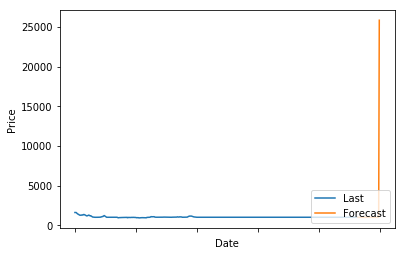

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)


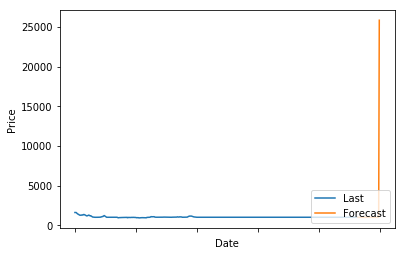

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


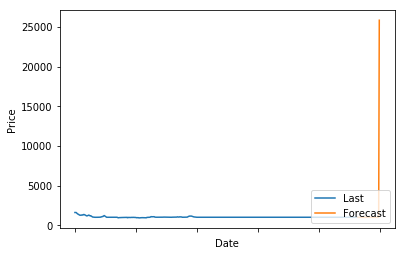

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])


In [13]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

#y_pred= clfpoly3.predict(test_X)
#rmse = sqrt(mean_squared_error(test_y, y_pred))
#print ("rmse= "+str(rmse))


forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan
    
s = str(dfreg.iloc[-1].name)
last_date = datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
last_unix = last_date
next_unix = last_unix + timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
        
models = [clfreg,clfpoly2,clfpoly3]
for model in models:
    dfreg['Last'].tail(500).plot()
    dfreg['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    print(str(model))
    
    